#Pytorch Adapter Network Tester MNIST Reduced

##Revision History and Current Todo

In [ ]:
#Niyana Yohannes - 500948752

#I acknowledge that the inspiration for the 1x1 adapter was from Sylvestre Rebuffi
#and Hakan Bilen's residual adapter code hosted here: https://github.com/srebuffi/residual_adapters
#and that I was inspired by their code.

#I acknowledge that the basic network was built off the tutorial by Nutan at
#https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

#I also acknowledge that the weight freezing logic was built off work by chenyuntc on
#https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

#I acknowledge that number of problems was inspired the posts
#of ptrblck - @ptrblck_de - Nvidia Engineer on https://discuss.pytorch.org https://discuss.pytorch.org/u/ptrblck/summary.

#I further acknowledge that inspiration was taken from other tutorials, forum posts and
#general learning materials or many small details of my code, including the printing the parameters,
#creating a subset from the data and debugging my work

#Datasets
#MNIST
#MNIST0to8
#ExtendedMNIST

#CNN SS-CNN
#CSA Serial Adapter on SS-CNN
#CPA Parallel Adapter on SS-CNN

#Architecture
#ReLU activation for conv and hidden layer
#Output has sigmoid


##Setup

In [ ]:
# Connect to Runtime - Python3 - T4 GPU

import torch
from torch import optim

#Might be redundant
from torchvision import datasets
import torchvision.datasets as datasets

from torchvision.transforms import ToTensor
from torchvision.transforms import v2

from torch.utils.data import DataLoader
from torch.utils.data import Subset

import torch.nn as nn

from torch.autograd import Variable

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np

import copy

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Datasets

##MNIST

###Import

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 126300458.54it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45591153.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45330786.20it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5147400.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



###Show Data

MNIST Train


Train data:  Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test data:  Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train data size:  torch.Size([60000, 28, 28])
Test data size:  torch.Size([10000, 28, 28])
Train example 6th row:  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0118, 0.0706, 0.0706, 0.0706, 0.4941, 0.5333,
        0.6863, 0.1020, 0.6510, 1.0000, 0.9686, 0.4980, 0.0000, 0.0000, 0.0000,
        0.0000])
Train example 6th row:  tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.,  18.,  18.,  18., 126., 136., 175.,  26., 166., 255., 247., 127.,
          0.,   0.,   0.,   0.])
Test example 5:  tensor(5)


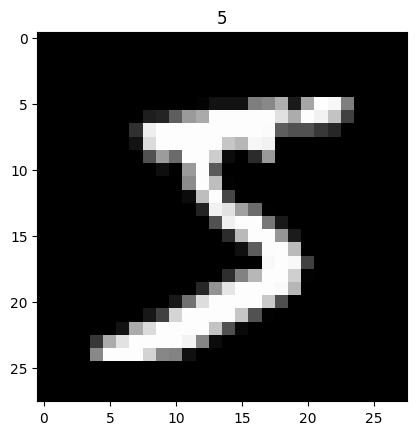

Targets[1:10]:  tensor([0, 4, 1, 9, 2, 1, 3, 1, 4])


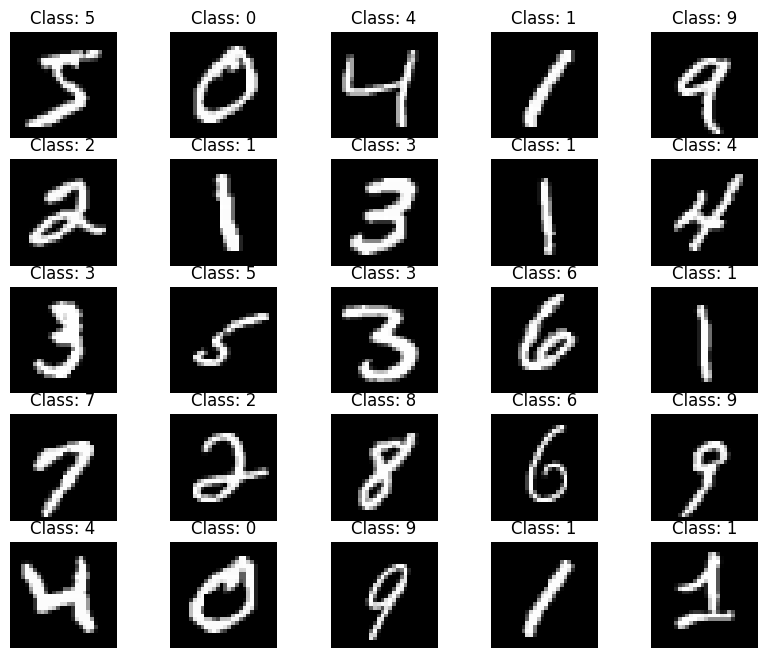

In [ ]:
fshowdata = 1
if fshowdata == 1:

  print("MNIST Train\n\n")

  print("Train data: ", train_data)
  print("Test data: ", test_data)
  print("Train data size: ", train_data.data.size())
  print("Test data size: ", test_data.data.size())
  print("Train example 6th row: ", train_data[0][0][0][5])
  print("Train example 6th row: ", train_data[0][0][0][5]*255)
  print("Test example 5: ", train_data.targets[0])

  plt.imshow(train_data.data[0], cmap='gray')
  plt.title('%i' % train_data.targets[0])
  plt.show()

  print("Targets[1:10]: ", train_data.targets[1:10])

  figure = plt.figure(figsize=(10, 8))
  cols, rows = 5, 5
  for i in range(0, cols * rows):

      # sample_idx = torch.randint(len(train_data), size=(1,)).item()

      img, label = train_data[i]

      figure.add_subplot(rows, cols, i+1)
      plt.title(f'Class: {label}')
      plt.axis("off")

      plt.imshow(img.squeeze(), cmap="gray")

  plt.show()

###Load Loaders

In [ ]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f140bea9c30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f140beaae00>}

##MNIST_reduced

###Import

In [ ]:
train_data_MNIST = datasets.MNIST(
    root = 'data_for_MNIST0to8',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data_MNIST = datasets.MNIST(
    root = 'data_for_MNIST0to8',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 171886402.89it/s]

Extracting data_for_MNIST0to8/MNIST/raw/train-images-idx3-ubyte.gz to data_for_MNIST0to8/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 98006224.78it/s]


Extracting data_for_MNIST0to8/MNIST/raw/train-labels-idx1-ubyte.gz to data_for_MNIST0to8/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41013926.91it/s]

Extracting data_for_MNIST0to8/MNIST/raw/t10k-images-idx3-ubyte.gz to data_for_MNIST0to8/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 24549650.47it/s]


Extracting data_for_MNIST0to8/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_for_MNIST0to8/MNIST/raw



###Remove class

In [ ]:
# MNIST Get all targets
ds = train_data_MNIST
ds_test = test_data_MNIST

print("MNIST Train:\n\n",ds.data.shape, "MNIST Train Targets: ",ds.targets.shape)
print("\nMNIST Train Targets\n\n ",ds.targets.unique(return_counts=True))
print("\nTotal size - class size\n\n", ds.targets.shape[0]-ds.targets.unique(return_counts=True)[1])
print(ds.classes,"\n\n")

print("MNIST Test\n",ds_test.data.shape, "MNIST Test Targets: ",ds_test.targets.shape)
print("\nMNIST Test Targets\n",ds_test.targets.unique(return_counts=True))
print("\nTotal size - class size\n", ds_test.targets.shape[0]-ds_test.targets.unique(return_counts=True)[1])
print(ds_test.classes)

targets = ds.targets
targets_test = ds_test.targets

print("\n\ntrain targets:", targets)
print("test targets:", targets_test)

train_idx = np.arange(len(targets))
test_idx = np.arange(len(targets_test))

print("\n\ntrain idx:", train_idx)
print("test idx:", test_idx)

idx1 = targets[train_idx]!=9
idx1_test = targets_test[test_idx]!=9

print("\n\ntrain idx1:", idx1)
print("test idx1:", idx1_test)

print("\n\nIdx1 (#false is #class_to_remove)\n\n", idx1.unique(return_counts=True))
print("\nIdx1_test (#false is #class_to_remove)\n\n", idx1_test.unique(return_counts=True))

# # Only keep your desired classes
train_idx = train_idx[idx1]
test_idx = test_idx[idx1_test]
print("\nConfirm count:\n\nTrain idx Shape:", train_idx.shape, "\nMatched size? ", train_idx.shape[0] == idx1.unique(return_counts=True)[1][1].item())
print("\nTest idx Shape:", test_idx.shape, "\nMatched size? ", test_idx.shape[0] == idx1_test.unique(return_counts=True)[1][1].item())


MNIST Train:

 torch.Size([60000, 28, 28]) MNIST Train Targets:  torch.Size([60000])

MNIST Train Targets

  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

Total size - class size

 tensor([54077, 53258, 54042, 53869, 54158, 54579, 54082, 53735, 54149, 54051])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] 


MNIST Test
 torch.Size([10000, 28, 28]) MNIST Test Targets:  torch.Size([10000])

MNIST Test Targets
 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

Total size - class size
 tensor([9020, 8865, 8968, 8990, 9018, 9108, 9042, 8972, 9026, 8991])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


train targets: tensor([5, 0, 4,  ..., 5, 6, 8])
test targets: tensor([7, 2, 1,  ..., 4, 5, 6])


train idx: [    0     

###Show Data

MNIST 0to8 Train

Shift classes by -1 (For N classes, train() needs classes 0..N-1)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])) 10
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])) 10

Dataloader Labels (Uniques)

 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([14, 17,  7, 13, 11,  6, 12, 12,  8])) 9

Nine classes.  Class removed successfully

Targets

 tensor([5, 0, 4, 1, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 4, 0, 1, 1, 2, 4,
        3, 2, 7, 3, 8, 6, 0, 5, 6, 0, 7, 6, 1, 8, 7, 3, 8, 5, 3, 3, 0, 7, 4, 8,
        0, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 0,
        2, 6, 7, 8, 3, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6,
        3, 0, 2, 3])


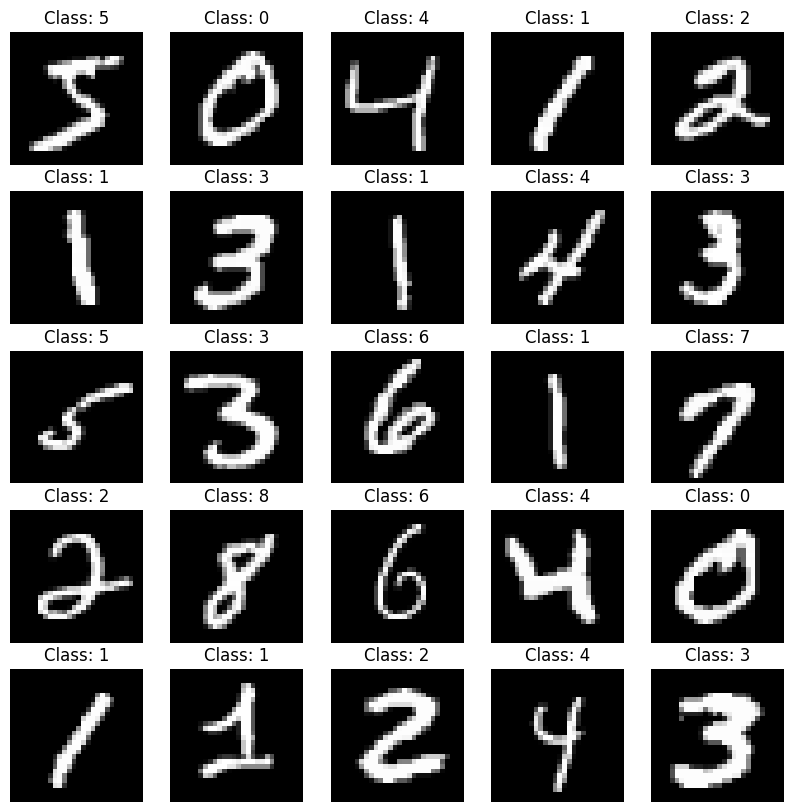

In [ ]:
train_dataset_MNIST0to8_ss = Subset(ds, train_idx)
test_dataset_MNIST0to8_ss = Subset(ds_test, test_idx)

torch.save(train_dataset_MNIST0to8_ss, 'train_MNIST0to8_subset.pt')
torch.save(test_dataset_MNIST0to8_ss, 'test_MNIST0to8_subset.pt')

train_data_MNIST0to8 = torch.load('train_MNIST0to8_subset.pt')
test_data_MNIST0to8 = torch.load('test_MNIST0to8_subset.pt')

train_data_MNIST0to8.dataset.targets = train_data_MNIST0to8.dataset.targets
test_data_MNIST0to8.dataset.targets = test_data_MNIST0to8.dataset.targets

train_dataset_MNIST0to8_ss_dataloader = DataLoader(train_data_MNIST0to8, shuffle=False, batch_size=100)

print("MNIST 0to8 Train\n")

print("Shift classes by -1 (For N classes, train() needs classes 0..N-1)\n")

print(train_data_MNIST0to8.dataset.targets.unique(return_counts=True), len(train_data_MNIST0to8.dataset.targets.unique(return_counts=True)[1]))
print(test_data_MNIST0to8.dataset.targets.unique(return_counts=True), len(test_data_MNIST0to8.dataset.targets.unique(return_counts=True)[1]))

print("")

for j, (images, targets) in enumerate(train_dataset_MNIST0to8_ss_dataloader):

    print("Dataloader Labels (Uniques)\n\n",targets.unique(return_counts=True), len(targets.unique()))
    if(len(targets.unique() == 9)):
      print("\nNine classes.  Class removed successfully")

    print("\nTargets\n\n",targets)

    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(f'Class: {targets[i]}')
      plt.axis("off")
      plt.imshow(images[i].squeeze(), cmap="gray")
    plt.show()

    if j == 0: break



MNIST 0to8 Test


Dataloader Labels (Uniques)

 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([ 9, 15,  9, 12, 16,  8, 11, 17,  3])) 9

Nine classes.  Class removed successfully

Targets

 tensor([7, 2, 1, 0, 4, 1, 4, 5, 0, 6, 0, 1, 5, 7, 3, 4, 6, 6, 5, 4, 0, 7, 4, 0,
        1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5,
        5, 6, 0, 4, 1, 5, 7, 8, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 1, 7, 3, 2, 7, 7,
        6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 3, 1, 4, 1, 7, 6, 6, 0, 5, 4, 2, 1, 4,
        8, 7, 3, 7])


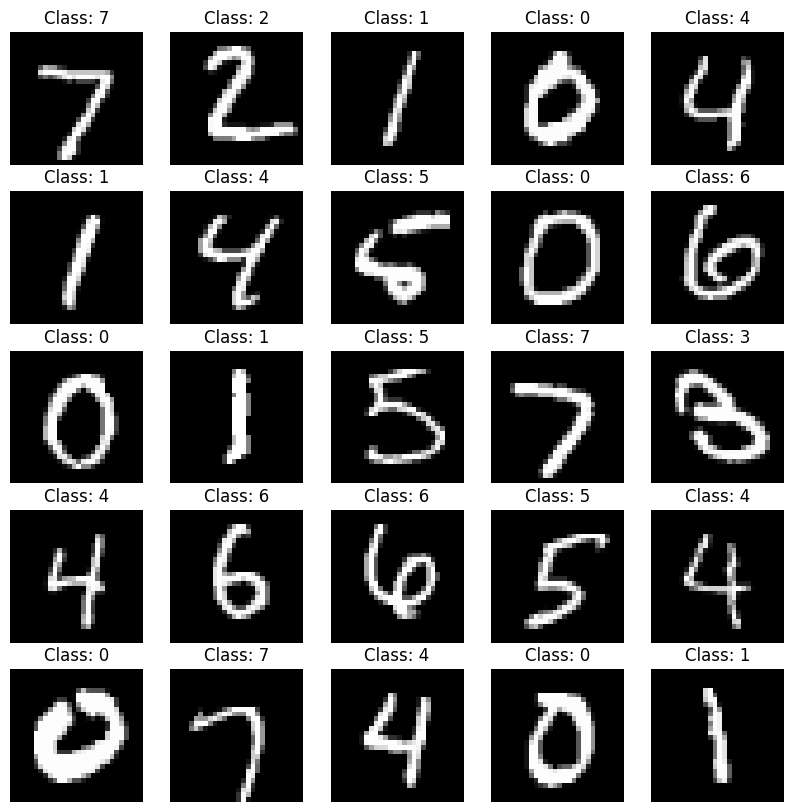

In [ ]:
test_dataset_MNIST0to8_ss_dataloader = DataLoader(test_data_MNIST0to8, shuffle=False, batch_size=100)

print("\n\nMNIST 0to8 Test\n\n")

for j, (images_test, targets_test) in enumerate(test_dataset_MNIST0to8_ss_dataloader):

    print("Dataloader Labels (Uniques)\n\n",targets_test.unique(return_counts=True), len(targets_test.unique(return_counts=True)[0]))

    if(len(targets_test.unique(return_counts=True)[0] == 9)):
      print("\nNine classes.  Class removed successfully")

    print("\nTargets\n\n",targets_test)

    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(f'Class: {targets_test[i]}')
      plt.axis("off")
      plt.imshow(images_test[i].squeeze(), cmap="gray")
    plt.show()

    if j == 0: break

###Load Loaders

In [ ]:
loaders_MNIST0to8 = {
      'train' : torch.utils.data.DataLoader(train_data_MNIST0to8,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=1),

      'test'  : torch.utils.data.DataLoader(test_data_MNIST0to8,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=1),
  }

print(loaders_MNIST0to8)
print(len(loaders_MNIST0to8['train']))
print(len(loaders_MNIST0to8['test']))

#Check there are 10 labels in MNIST and 9 in MNIST 0to8

for inputs, labels in loaders['train']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

for inputs, labels in loaders_MNIST0to8['train']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

  #Check there are 10 labels in MNIST and 9 in MNIST 0to8

for inputs, labels in loaders['test']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

for inputs, labels in loaders_MNIST0to8['test']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1402c54310>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f1402c54910>}
541
90
Shape: torch.Size([100]),
 Labels: tensor([0, 4, 9, 4, 8, 6, 3, 8, 8, 6, 0, 8, 7, 8, 4, 3, 2, 9, 4, 7, 1, 5, 8, 7,
        9, 1, 6, 1, 3, 0, 2, 9, 8, 7, 3, 4, 2, 3, 8, 7, 0, 8, 7, 3, 7, 8, 5, 8,
        7, 0, 0, 7, 2, 9, 4, 7, 9, 7, 0, 3, 1, 7, 8, 4, 5, 8, 4, 7, 2, 2, 0, 4,
        1, 4, 0, 6, 3, 5, 1, 7, 8, 4, 2, 9, 6, 5, 2, 4, 9, 1, 6, 9, 9, 1, 2, 3,
        5, 4, 2, 3]),
 Uniques: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 9,  8, 10, 10, 13,  6,  6, 14, 14, 10])),
 Len 10
Shape: torch.Size([100]),
 Labels: tensor([5, 5, 3, 5, 0, 1, 8, 7, 7, 4, 0, 7, 3, 5, 3, 0, 2, 1, 0, 5, 6, 5, 7, 1,
        0, 7, 5, 1, 2, 4, 2, 8, 3, 7, 0, 4, 3, 8, 6, 5, 3, 1, 1, 1, 2, 1, 5, 5,
        3, 3, 6, 4, 7, 2, 1, 4, 8, 5, 5, 1, 0, 3, 0, 6, 4, 7, 8, 4, 6, 8, 4, 3,
        5, 7, 1, 4, 7, 1, 6, 0, 4, 0, 1, 6, 0, 8, 5, 3, 2, 8, 6, 1, 3, 1, 6, 5,

In [ ]:
# for i, (images, labels) in enumerate(loaders['train']):
#   print(i)
#   print(labels)
#   print(len(labels))

#Networks

##Functions

In [ ]:
def save_network(network):
  store_network_tensors = []

  for named_param in network.named_parameters():
      store_network_tensors.append(named_param)

  return store_network_tensors


In [ ]:
def check_network(network1, network2):
  for named_param in network1.named_parameters():
      # print(f"For {named_param[0]}")
      for stored_param in network2.named_parameters():
        if(named_param[0] in stored_param[0]):
          # print(named_param[1])
          # print(stored_param[1])
          if(named_param[1].shape == stored_param[1].shape):
            print(f"{torch.allclose(named_param[1],stored_param[1])} is same for {named_param[0]}")
          else:
            print(f"Shapes do not match for {named_param[0]} and {stored_param[0]}")

In [ ]:
def load_state_dict_conv_layer(network, state):

      # with torch.no_grad():
        network_state = network.state_dict()
        # print(network_state['conv1.weight'][0:1])
        # print(sscnn_sa_1to9.state_dict()['conv1.weight'][0:1])
        for name, param in state.items():
            if(name == 'conv1.weight' or name == 'conv1.bias'):
              # print("State to load: ", name, param[0])
              # print("Network before: ", name, network_state[name][0])
              # print(param.requires_grad)
              network_state[name].copy_(param)
              # print("Network after: ", name, network_state[name][0])

              # if isinstance(param, Parameter):
              #     # backwards compatibility for serialized parameters
              #     param = param.data
              # net_state[name].copy_(param)

In [ ]:
def train(num_epochs, cnn, loaders, optimizer, loss_func):

    print("Training beginning")
    cnn.train()

    # Train the model
    total_step = len(loaders['train'])
    count = 0

    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(loaders['train']):

          # gives batch data, normalize x when iterate train_loader
          b_x = Variable(images)   # batch x
          b_y = Variable(labels)   # batch y

          output = cnn(b_x)

          loss = loss_func(output, b_y)

          # clear gradients for this training step
          optimizer.zero_grad()

          # backpropagation, compute gradients
          loss.backward()
          # apply gradients
          optimizer.step()

          if (i+1) % total_step == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
          pass
        pass
    pass

In [ ]:
def old_test(cnn, loaders):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output = cnn(images)

            # Take maximum label prediction
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

            pass

        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

    pass


In [ ]:
def test_and_show(cnn, loaders, text=0, graph_mode=0, rotate=False):
    # Test the model
    cnn.eval()
    with torch.no_grad():

        correct = 0
        total = 0
        accuracy = 0
        # print(f"C: {correct}, T: {total}, A: {accuracy}")

        for images, labels in loaders['test']:

            #Batches
            # print(f"\nLengths\nImages: {len(images)}, Labels: {len(labels)}")
            total = total + len(images)

            test_output = cnn(images)

            # print("Out: ", test_output.shape, test_output[0:2])

            # Take maximum label prediction
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            # print("Pred_y: ", pred_y.shape, pred_y)
            # print("Pred_y == labels ", (pred_y == labels).shape, (pred_y == labels), (pred_y == labels).sum().item())

            correct = correct + (pred_y == labels).sum().item()
            # print(f"C: {correct}, T: {total}, A: {accuracy}")
            # print(f"accuracy per 100 {(pred_y == labels).sum().item() / float(labels.size(0))}")

        print(f"C: {correct}, T: {total}, A: {accuracy}")
        accuracy = correct/total
        print(f'Test Accuracy of the model on the {total} test images. Correct: {correct} : {accuracy}')

    if(graph_mode >= 1):

      sample = next(iter(loaders['test']))

      imgs, lbls = sample
      actual_number = lbls[:100].numpy()
      actual_number

      test_output = cnn(imgs[:100])

      pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
      print("Targets: ", torch.from_numpy(actual_number).unique(return_counts=True), len(actual_number), len(pred_y))


      if(graph_mode >= 2):

        figure = plt.figure(figsize=(10, 8))
        cols, rows = 5, 5
        for i in range(0, cols * rows):
              # sample_idx = torch.randint(len(train_data), size=(1,)).item()
              # img, label = train_data[i]
              figure.add_subplot(rows, cols, i+1)
              plt.title(lbls[i])
              plt.axis("off")
              if(rotate == True):
                plt.imshow(torch.flip(torch.rot90(imgs[i].squeeze(),1),[0]), cmap="gray")
              else:
                plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.show()

        figure = plt.figure(figsize=(10, 8))
        cols, rows = 5, 5
        for i in range(0, cols * rows):
              # sample_idx = torch.randint(len(train_data), size=(1,)).item()
              # img, label = train_data[i]
              figure.add_subplot(rows, cols, i+1)
              plt.title(pred_y[i])
              plt.axis("off")
              if(rotate == True):
                plt.imshow(torch.flip(torch.rot90(imgs[i].squeeze(),1),[0]), cmap="gray")
              else:
                plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.show()

    if(text == True):
        count_25 = 0
        count_nine = 0
        for x in np.arange(0, len(pred_y)):
          count_25 = count_25+1
          if(count_25 < 26):
            print(f'P: {pred_y[x]} A: {actual_number[x]} T: {(pred_y == actual_number)[x]}')
            if(actual_number[x] == 0):
              print(f'Zero {(pred_y == actual_number)[x]}')
            elif (actual_number[x] == 9):
              print(f'Nine {(pred_y == actual_number)[x]}')
              count_nine = count_nine + 1
          else:
            break

        if count_nine == 0:
          print("No nine class detected")
        else:
          print("Class nine detected")



##Definitions

In [ ]:
class SSCNN(nn.Module):

    # Default parameters
    def __init__(self, outc = 6, out_class = 10, adapt=0):

        super(SSCNN, self).__init__()
        self.outc = outc
        self.KxK = 5
        self.out_class = out_class
        self.adapt = adapt

        self.conv1 = nn.Conv2d(
                #KxK
                in_channels=1,
                out_channels= self.outc,
                kernel_size=self.KxK,
                stride=1,
                padding=2,
                bias=True,
            )

        self.conv1sa = nn.Conv2d(
                #1x1 serial
                in_channels=self.outc,
                out_channels= self.outc,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

        self.conv1pa = nn.Conv2d(
                #1x1 parallel
                in_channels=1,
                out_channels= self.outc,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

        # self.actv = nn.ReLU()
        self.actv = nn.Sigmoid()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        #If Conv Padding = 2
        self.fc = nn.Linear(196*self.outc, 45, bias=True)

        #else Conv Padding = 0
        # self.fc = nn.Linear(144*self.outc, 45, bias=True)

        self.out = nn.Linear(45,self.out_class, bias=True)

    def forward(self, x):

        if(self.adapt == 0):
          x = self.conv1(x)
          x = self.actv(x)
          x = self.pool(x)

        elif(self.adapt == 1):
          #Add conv outputs in serial before activation
          x = self.conv1(x)
          dx = self.conv1sa(x)
          x = self.actv(x + dx)
          x = self.pool(x)

        elif(self.adapt == 2):
          #Add conv outputs in parallel before activation
          xc = self.conv1(x)
          dx = self.conv1pa(x)
          # print(xc.shape)
          # print(dx.shape)
          x = self.actv(xc + dx)
          x = self.pool(x)

        # Flatten output for FC
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.actv(x)

        output = self.out(x)
        # output_actv = self.actv(output)

        return output # should return [batch_size, numclass] for use in train()

        #return output, x  #for visualisation

#Train Network MNIST

In [ ]:
outchannels = 6
outclass = 10

##SSCNN

###Initialise and Train

####Initialise

In [ ]:
sscnn = SSCNN(outc = outchannels, out_class = outclass, adapt = 0)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(sscnn.parameters(), lr = 1.5)
print("SSCNN Outc: ", sscnn.outc)
print("SSCNN Outclass: ", sscnn.out_class)
print("SSCNN Adapt: ", sscnn.adapt)

SSCNN Outc:  6
SSCNN Outclass:  10
SSCNN Adapt:  0


In [ ]:
print(sscnn)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


####Train

In [ ]:
print("sscnn")
# saved_network_param = save_network(sscnn)
# check_network(sscnn, saved_network_param)
num_epochs = 15
copy_sscnn = copy.deepcopy(sscnn)
train(num_epochs, sscnn, loaders, optimizer, loss_func)
check_network(sscnn, copy_sscnn)

sscnn
Training beginning
Epoch [1/15], Step [600/600], Loss: 0.29
Epoch [2/15], Step [600/600], Loss: 0.26
Epoch [3/15], Step [600/600], Loss: 0.05
Epoch [4/15], Step [600/600], Loss: 0.05
Epoch [5/15], Step [600/600], Loss: 0.04
Epoch [6/15], Step [600/600], Loss: 0.04
Epoch [7/15], Step [600/600], Loss: 0.02
Epoch [8/15], Step [600/600], Loss: 0.07
Epoch [9/15], Step [600/600], Loss: 0.02
Epoch [10/15], Step [600/600], Loss: 0.04
Epoch [11/15], Step [600/600], Loss: 0.04
Epoch [12/15], Step [600/600], Loss: 0.02
Epoch [13/15], Step [600/600], Loss: 0.03
Epoch [14/15], Step [600/600], Loss: 0.02
Epoch [15/15], Step [600/600], Loss: 0.01
False is same for conv1.weight
False is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias


####Accuracy

In [ ]:
# test(sscnn, loaders_MNIST)
test_and_show(sscnn, loaders, text=False, graph_mode=0, rotate=False)

C: 9862, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9862 : 0.9862


C: 9862, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9862 : 0.9862
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([11,  9,  6, 14, 10, 10,  8, 12, 11,  9])) 100 100


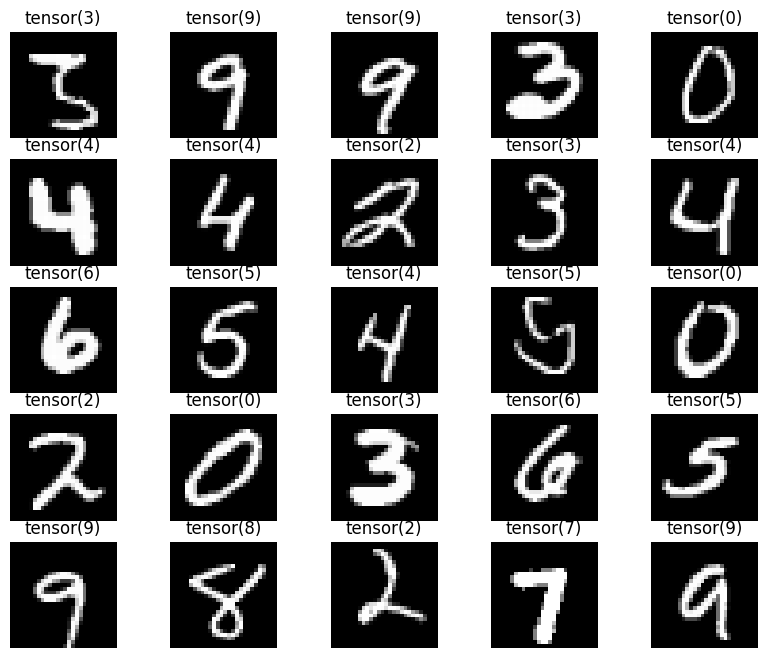

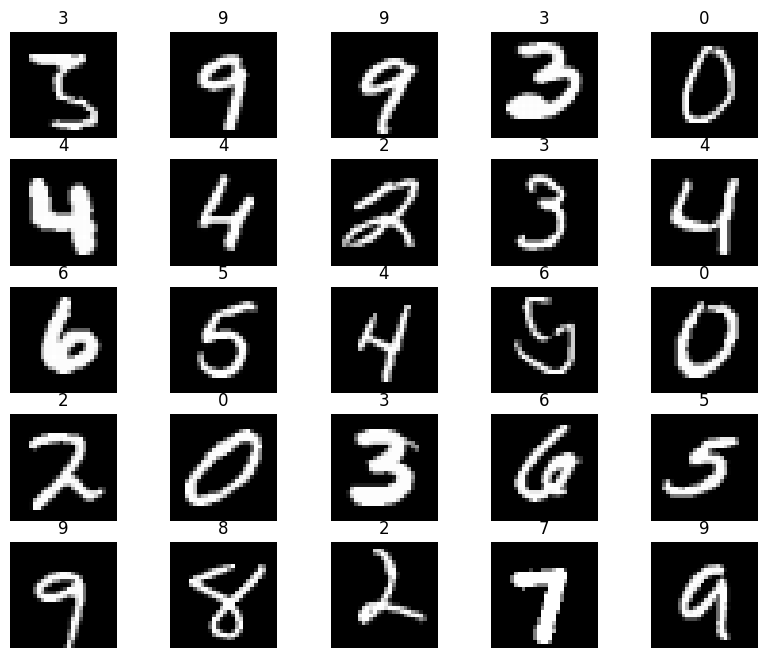

In [ ]:
test_and_show(sscnn, loaders, text=False, graph_mode=2, rotate=False)

#Train Networks MNIST0to8

In [ ]:
outchannels = 3
outclass = 10

outchannels_0to8 = 3
outclass_0to8 = 9

##SSCNN

###Initialise and Train

####Initialise

In [ ]:
sscnn_0to8 = SSCNN(outc = outchannels_0to8, out_class = outclass_0to8, adapt = 0)
loss_func_sscnn_0to8 = nn.CrossEntropyLoss()
optimizer_sscnn_0to8 = optim.SGD(sscnn_0to8.parameters(), lr = 1.5)
print("SSCNN Outc: ", sscnn_0to8.outc)
print("SSCNN Outclass: ", sscnn_0to8.out_class)
print("SSCNN Adapt: ", sscnn_0to8.adapt)

SSCNN Outc:  3
SSCNN Outclass:  9
SSCNN Adapt:  0


In [ ]:
print(sscnn_0to8)

SSCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=588, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=9, bias=True)
)


####Train

In [ ]:
for named_param in sscnn_0to8.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)


SSCNN:  conv1.weight tensor([[ 0.1530,  0.1804,  0.1492, -0.1801, -0.0077],
        [-0.0213,  0.0268,  0.1955,  0.1844,  0.1126],
        [ 0.0596, -0.0752, -0.1319, -0.1535,  0.1420],
        [ 0.1286,  0.1464,  0.0720,  0.1391, -0.1756],
        [ 0.0605, -0.1499, -0.0830, -0.0504,  0.0771]],
       grad_fn=<SelectBackward0>) True

SSCNN:  conv1sa.weight tensor([[[0.0483]],

        [[0.5706]],

        [[0.3475]]], grad_fn=<SelectBackward0>) True

SSCNN:  conv1pa.weight Parameter containing:
tensor([[[[-0.1895]]],


        [[[-0.0276]]],


        [[[-0.9158]]]], requires_grad=True) True

SSCNN Others:  fc.weight tensor(0.0252, grad_fn=<SelectBackward0>) True

SSCNN Others:  out.weight tensor(0.1475, grad_fn=<SelectBackward0>) True


In [ ]:
print("sscnn_0to8")
# saved_network_param = save_network(sscnn_1to9)
# check_network(sscnn_1to9, saved_network_param)
num_epochs = 15
copy_sscnn_0to8 = copy.deepcopy(sscnn_0to8)
train(num_epochs, sscnn_0to8, loaders_MNIST0to8, optimizer_sscnn_0to8, loss_func_sscnn_0to8)
check_network(sscnn_0to8, copy_sscnn_0to8)

sscnn_0to8
Training beginning
Epoch [1/15], Step [541/541], Loss: 0.05
Epoch [2/15], Step [541/541], Loss: 0.13
Epoch [3/15], Step [541/541], Loss: 0.20
Epoch [4/15], Step [541/541], Loss: 0.03
Epoch [5/15], Step [541/541], Loss: 0.03
Epoch [6/15], Step [541/541], Loss: 0.06
Epoch [7/15], Step [541/541], Loss: 0.04
Epoch [8/15], Step [541/541], Loss: 0.14
Epoch [9/15], Step [541/541], Loss: 0.01
Epoch [10/15], Step [541/541], Loss: 0.09
Epoch [11/15], Step [541/541], Loss: 0.04
Epoch [12/15], Step [541/541], Loss: 0.02
Epoch [13/15], Step [541/541], Loss: 0.04
Epoch [14/15], Step [541/541], Loss: 0.03
Epoch [15/15], Step [541/541], Loss: 0.01
False is same for conv1.weight
False is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias


In [ ]:
for named_param in sscnn_0to8.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)


SSCNN:  conv1.weight tensor([[ 1.4629,  1.5484,  0.5125,  0.5943,  2.4912],
        [-0.0214,  1.3613,  1.1784,  1.8034,  1.4836],
        [-2.1880,  0.7160,  0.8190,  0.1612, -1.9535],
        [-3.6087, -1.7105, -2.0613, -2.8509, -2.8609],
        [-1.6882, -2.1607, -2.7544, -0.7828,  0.7039]],
       grad_fn=<SelectBackward0>) True

SSCNN:  conv1sa.weight tensor([[[ 0.3356]],

        [[ 0.3289]],

        [[-0.2564]]], grad_fn=<SelectBackward0>) True

SSCNN:  conv1pa.weight Parameter containing:
tensor([[[[-0.4525]]],


        [[[ 0.9910]]],


        [[[-0.4063]]]], requires_grad=True) True

SSCNN Others:  fc.weight tensor(0.0076, grad_fn=<SelectBackward0>) True

SSCNN Others:  out.weight tensor(-0.9598, grad_fn=<SelectBackward0>) True


####Accuracy

In [ ]:
# test(sscnn_1to9, loaders_MNIST1to9)
test_and_show(sscnn_0to8, loaders_MNIST0to8, text=False, graph_mode=0, rotate=False)

C: 8843, T: 8991, A: 0
Test Accuracy of the model on the 8991 test images. Correct: 8843 : 0.9835390946502057


C: 8843, T: 8991, A: 0
Test Accuracy of the model on the 8991 test images. Correct: 8843 : 0.9835390946502057
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([16, 10, 14, 11, 13,  8,  7, 13,  8])) 100 100


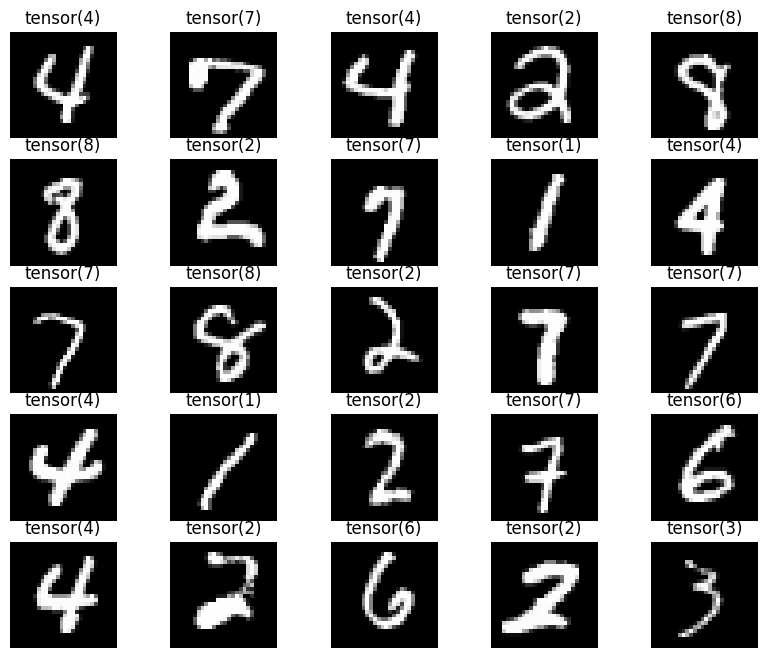

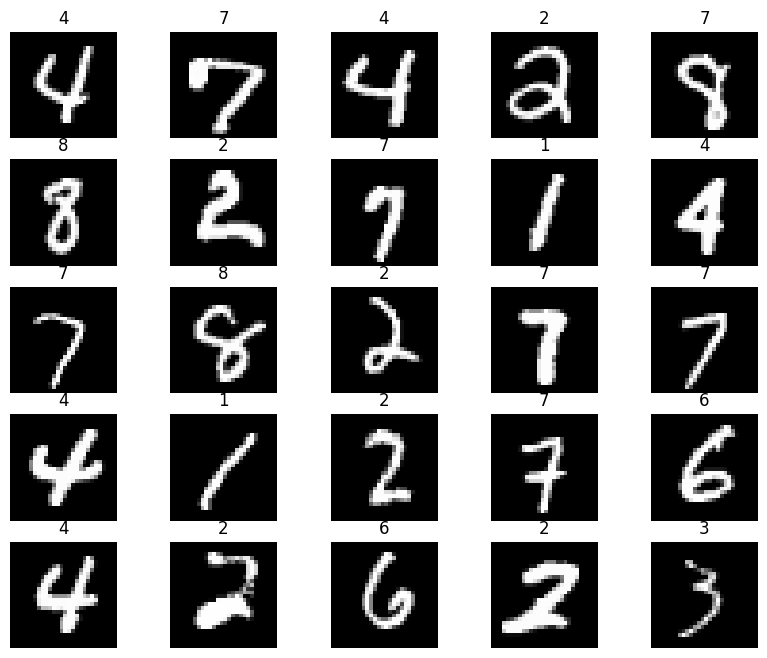

In [ ]:
test_and_show(sscnn_0to8, loaders_MNIST0to8, text=False, graph_mode=2, rotate=False)

##SSCNN_SA_0to8

###Initialise and Train

####Initialise

In [ ]:
sscnn_sa_0to8 = SSCNN(outc = outchannels, out_class = outclass, adapt = 1)
loss_func_sscnn_sa_0to8 = nn.CrossEntropyLoss()
optimizer_sscnn_sa_0to8 = optim.SGD(sscnn_sa_0to8.parameters(), lr = 1.5)
print("SSCNN Outc: ", sscnn_sa_0to8.outc)
print("SSCNN Outclass: ", sscnn_sa_0to8.out_class)
print("SSCNN Adapt: ", sscnn_sa_0to8.adapt)

SSCNN Outc:  3
SSCNN Outclass:  10
SSCNN Adapt:  1


In [ ]:
print(sscnn_sa_0to8)

SSCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=588, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
copy_sscnn_0to8 = copy.deepcopy(sscnn_0to8)
copy_sscnn_0to8.train()

load_state_dict_conv_layer(sscnn_sa_0to8, copy_sscnn_0to8.state_dict())

# print(sscnn_sa_1to9.state_dict()['conv1.weight'][0:1])
# print(sscnn_sa_1to9.conv1)
# print(f"For conv1.weight: {torch.allclose(sscnn_1to9.state_dict()['conv1.weight'],sscnn_sa_1to9.state_dict()['conv1.weight'])}")

for param in sscnn_sa_0to8.conv1.parameters():
  # print(param)
  # print("Train (Grad)?:", param.requires_grad)
  param.requires_grad = False
  # print("Train (Grad)?:", param.requires_grad)


In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Should be False True for conv1 and True False for the rest (except output layer due to size)\n")

print("Name\t\t Grad\t\t Values close?")

for named_param in sscnn_0to8.named_parameters():
  for named_param2 in sscnn_sa_0to8.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Should be False True for conv1 and True False for the rest (except output layer due to size)

Name		 Grad		 Values close?
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias


####Train

In [ ]:
# num_epochs = 20

print("Training sscnn_sa_0to8")
copy_sscnn_sa_1to9 = copy.deepcopy(sscnn_sa_0to8)
train(num_epochs, sscnn_sa_0to8, loaders, optimizer_sscnn_sa_0to8, loss_func_sscnn_sa_0to8)
print("")
print("Test sameness of SA sscnn before training to after training")
check_network(sscnn_sa_0to8, copy_sscnn_sa_1to9)
print("")
print("Test sameness of ssccn to serial adapter sscnn")
check_network(sscnn_sa_0to8, sscnn_0to8)

Training sscnn_sa_0to8
Training beginning
Epoch [1/15], Step [600/600], Loss: 0.08
Epoch [2/15], Step [600/600], Loss: 0.19
Epoch [3/15], Step [600/600], Loss: 0.04
Epoch [4/15], Step [600/600], Loss: 0.15
Epoch [5/15], Step [600/600], Loss: 0.05
Epoch [6/15], Step [600/600], Loss: 0.07
Epoch [7/15], Step [600/600], Loss: 0.07
Epoch [8/15], Step [600/600], Loss: 0.02
Epoch [9/15], Step [600/600], Loss: 0.02
Epoch [10/15], Step [600/600], Loss: 0.03
Epoch [11/15], Step [600/600], Loss: 0.01
Epoch [12/15], Step [600/600], Loss: 0.05
Epoch [13/15], Step [600/600], Loss: 0.04
Epoch [14/15], Step [600/600], Loss: 0.06
Epoch [15/15], Step [600/600], Loss: 0.01

Test sameness of SA sscnn before training to after training
True is same for conv1.weight
True is same for conv1.bias
False is same for conv1sa.weight
False is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is 

####Accuracy

In [ ]:
# test(sscnn_sa_1to9, loaders)
test_and_show(sscnn_sa_0to8, loaders, text=False, graph_mode=0, rotate=False)

C: 9790, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9790 : 0.979


C: 9790, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9790 : 0.979
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([12,  8,  9, 11, 18,  5,  5, 12, 10, 10])) 100 100


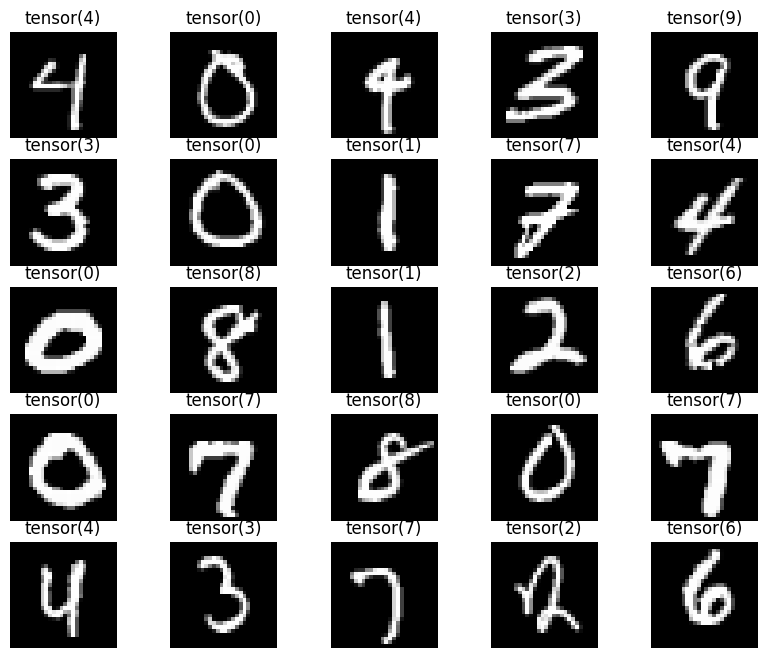

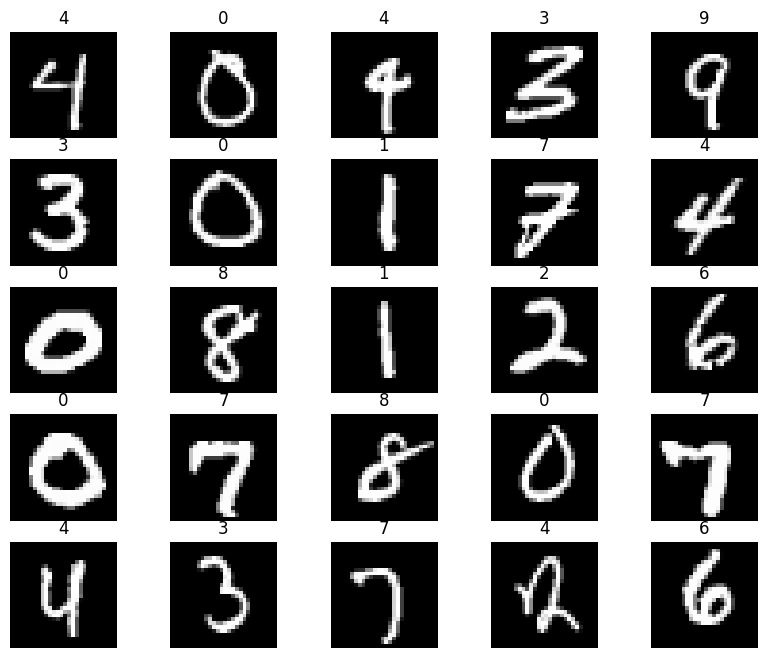

In [ ]:
test_and_show(sscnn_sa_0to8, loaders, text=False, graph_mode=2, rotate=False)

##SSCNN_PA

###Initialise and Train

####Initialise

In [ ]:
sscnn_pa_0to8 = SSCNN(outc = outchannels, out_class = outclass, adapt = 2)
loss_func_sscnn_pa_0to8 = nn.CrossEntropyLoss()
optimizer_sscnn_pa_0to8 = optim.SGD(sscnn_pa_0to8.parameters(), lr = 1.5)
print("SSCNN Outc: ", sscnn_pa_0to8.outc)
print("SSCNN Outclass: ", sscnn_pa_0to8.out_class)
print("SSCNN Adapt: ", sscnn_pa_0to8.adapt)

SSCNN Outc:  3
SSCNN Outclass:  10
SSCNN Adapt:  2


In [ ]:
print(sscnn_pa_0to8)

SSCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=588, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
copy_sscnn_1to9 = copy.deepcopy(sscnn_0to8)
copy_sscnn_1to9.train()

load_state_dict_conv_layer(sscnn_pa_0to8, copy_sscnn_1to9.state_dict())

# print(sscnn_pa_1to9.state_dict()['conv1.weight'][0:1])
# print(sscnn_pa_1to9.conv1)
# print(f"For conv1.weight: {torch.allclose(sscnn_1to9.state_dict()['conv1.weight'],sscnn_pa_1to9.state_dict()['conv1.weight'])}")

for param in sscnn_pa_0to8.conv1.parameters():
  # print(param)
  # print("Train (Grad)?:", param.requires_grad)
  param.requires_grad = False
  # print("Train (Grad)?:", param.requires_grad)


In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Should be False True for conv1 and True False for the rest (except output layer due to size)\n")

print("Name\t\t Grad\t\t Values close?")

for named_param in sscnn_0to8.named_parameters():
  for named_param2 in sscnn_pa_0to8.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Should be False True for conv1 and True False for the rest (except output layer due to size)

Name		 Grad		 Values close?
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias


####Train

In [ ]:
# num_epochs = 15

print("Training sscnn_pa_1to9")

copy_sscnn_pa_0to8 = copy.deepcopy(sscnn_pa_0to8)
train(num_epochs, sscnn_pa_0to8, loaders, optimizer_sscnn_pa_0to8, loss_func_sscnn_pa_0to8)
check_network(sscnn_pa_0to8, copy_sscnn_pa_0to8)

print("")
print("Test sameness of SA sscnn before training to after training")
check_network(sscnn_pa_0to8, copy_sscnn_pa_0to8)
print("")
print("Test sameness of ssccn to serial adapter sscnn")
check_network(sscnn_pa_0to8, sscnn_0to8)

Training sscnn_pa_1to9
Training beginning
Epoch [1/15], Step [600/600], Loss: 0.09
Epoch [2/15], Step [600/600], Loss: 0.08
Epoch [3/15], Step [600/600], Loss: 0.07
Epoch [4/15], Step [600/600], Loss: 0.03
Epoch [5/15], Step [600/600], Loss: 0.08
Epoch [6/15], Step [600/600], Loss: 0.10
Epoch [7/15], Step [600/600], Loss: 0.12
Epoch [8/15], Step [600/600], Loss: 0.11
Epoch [9/15], Step [600/600], Loss: 0.05
Epoch [10/15], Step [600/600], Loss: 0.08
Epoch [11/15], Step [600/600], Loss: 0.02
Epoch [12/15], Step [600/600], Loss: 0.04
Epoch [13/15], Step [600/600], Loss: 0.04
Epoch [14/15], Step [600/600], Loss: 0.04
Epoch [15/15], Step [600/600], Loss: 0.01
True is same for conv1.weight
True is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
False is same for conv1pa.weight
False is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias

Test sameness of SA sscnn before training 

####Accuracy

In [ ]:
# test(sscnn_pa_1to9, loaders)
test_and_show(sscnn_pa_0to8, loaders, text=False, graph_mode=0, rotate=False)

C: 9820, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9820 : 0.982


C: 9820, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9820 : 0.982
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 6, 16, 16,  6, 13,  8, 12,  6, 11,  6])) 100 100


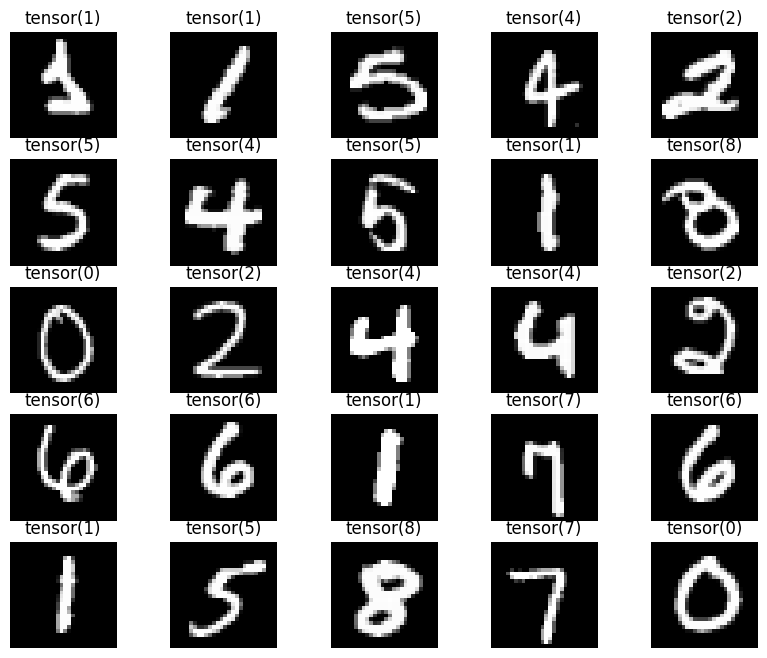

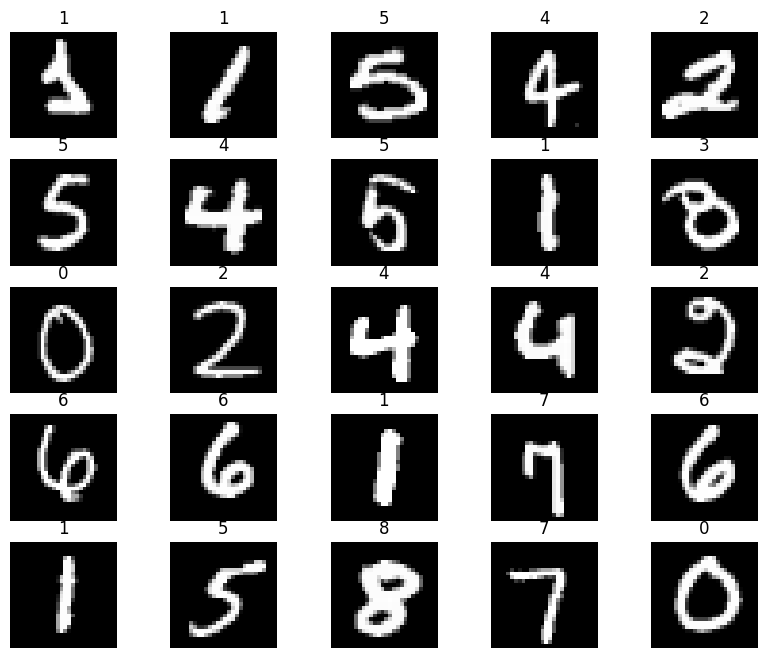

In [ ]:
test_and_show(sscnn_pa_0to8, loaders, text=False, graph_mode=2, rotate=False)

##SSCNN_FT

###Initialise and Train

####Initialise

In [ ]:
sscnn_0to8_ft = SSCNN(outc = outchannels_0to8, out_class = 10, adapt = 0)
loss_func_sscnn_0to8_ft = nn.CrossEntropyLoss()
optimizer_sscnn_0to8_ft = optim.SGD(sscnn_0to8_ft.parameters(), lr = 1.5)
print("SSCNN Outc: ", sscnn_0to8_ft.outc)
print("SSCNN Outclass: ", sscnn_0to8_ft.out_class)
print("SSCNN Adapt: ", sscnn_0to8_ft.adapt)

SSCNN Outc:  3
SSCNN Outclass:  10
SSCNN Adapt:  0


In [ ]:
print(sscnn_0to8_ft)

SSCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=588, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
def load_state_dict(network, state):

      with torch.no_grad():
        net_state = network.state_dict()
        for name, param in state.items():
            if name not in net_state:
                  continue
            else:
              print(name, param[0:1])
              print(net_state[name][0:1])
              if( net_state[name].shape != param.shape):
                print("Shape's do not match for ", name, net_state[name].shape)
                print("Before: ", net_state[name][0:1], net_state[name].shape)
                # net_state[name] = copy.deepcopy(param)
                print("After: ", net_state[name], net_state[name].shape)

              else:
                net_state[name] = copy.deepcopy(param)
                print("Updated name")

            # if isinstance(param, Parameter):
            #     # backwards compatibility for serialized parameters
            #     param = param.data
            # net_state[name].copy_(param)

copy_sscnn_0to8_for_ft = copy.deepcopy(sscnn_0to8)
copy_sscnn_0to8_for_ft.train()

load_state_dict(sscnn_0to8_ft, copy_sscnn_0to8_for_ft.state_dict())



# for param in copy_sscnn_1to9_for_ft.state_dict():
#   print(param, " contains ", copy_sscnn_1to9_for_ft.state_dict()[param])
#   if param == "conv1.weight":
#     sscnn_1to9_for_ft.state_dict()[param] = copy_sscnn_1to9_for_ft.state_dict()[param];




conv1.weight tensor([[[[ 1.4629,  1.5484,  0.5125,  0.5943,  2.4912],
          [-0.0214,  1.3613,  1.1784,  1.8034,  1.4836],
          [-2.1880,  0.7160,  0.8190,  0.1612, -1.9535],
          [-3.6087, -1.7105, -2.0613, -2.8509, -2.8609],
          [-1.6882, -2.1607, -2.7544, -0.7828,  0.7039]]]])
tensor([[[[-0.1034,  0.1338, -0.0174, -0.1788, -0.0631],
          [-0.0372,  0.0122,  0.1752,  0.0922,  0.0941],
          [-0.1098, -0.1962, -0.1128, -0.0237,  0.0462],
          [ 0.1541,  0.0663,  0.0198,  0.0887,  0.1953],
          [ 0.1348,  0.0536,  0.0331,  0.0508, -0.1453]]]])
Updated name
conv1.bias tensor([-3.2861])
tensor([0.1461])
Updated name
conv1sa.weight tensor([[[[ 0.3356]],

         [[ 0.3289]],

         [[-0.2564]]]])
tensor([[[[-0.2723]],

         [[-0.5755]],

         [[ 0.1370]]]])
Updated name
conv1sa.bias tensor([-0.4027])
tensor([-0.2045])
Updated name
conv1pa.weight tensor([[[[-0.4525]]]])
tensor([[[[0.4105]]]])
Updated name
conv1pa.bias tensor([-0.1474])
ten

In [ ]:
print(sscnn_0to8_ft)

SSCNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=588, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


####Train

In [ ]:
# num_epochs = 15

In [ ]:
print("sscnn_0to8_ft")

copy_sscnn_0to8_ft = copy.deepcopy(sscnn_0to8_ft)
train(num_epochs, sscnn_0to8_ft, loaders, optimizer_sscnn_0to8_ft, loss_func_sscnn_0to8_ft)
check_network(sscnn_0to8_ft, copy_sscnn_0to8_ft)

sscnn_0to8_ft
Training beginning
Epoch [1/15], Step [600/600], Loss: 0.20
Epoch [2/15], Step [600/600], Loss: 0.19
Epoch [3/15], Step [600/600], Loss: 0.14
Epoch [4/15], Step [600/600], Loss: 0.11
Epoch [5/15], Step [600/600], Loss: 0.10
Epoch [6/15], Step [600/600], Loss: 0.09
Epoch [7/15], Step [600/600], Loss: 0.06
Epoch [8/15], Step [600/600], Loss: 0.02
Epoch [9/15], Step [600/600], Loss: 0.07
Epoch [10/15], Step [600/600], Loss: 0.03
Epoch [11/15], Step [600/600], Loss: 0.02
Epoch [12/15], Step [600/600], Loss: 0.02
Epoch [13/15], Step [600/600], Loss: 0.06
Epoch [14/15], Step [600/600], Loss: 0.09
Epoch [15/15], Step [600/600], Loss: 0.02
False is same for conv1.weight
False is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias


In [ ]:
check_network(sscnn_0to8_ft, copy_sscnn_0to8_ft)
check_network(sscnn_0to8_ft, sscnn_0to8)

for named_param in sscnn_0to8.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

for named_param in sscnn_0to8_ft.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNNft: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNNft Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

False is same for conv1.weight
False is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias
False is same for conv1.weight
False is same for conv1.bias
False is same for conv1sa.weight
False is same for conv1sa.bias
False is same for conv1pa.weight
False is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
Shapes do not match for out.weight and out.weight
Shapes do not match for out.bias and out.bias

SSCNN:  conv1.weight tensor([[ 1.4629,  1.5484,  0.5125,  0.5943,  2.4912],
        [-0.0214,  1.3613,  1.1784,  1.8034,  1.4836],
        [-2.1880,  0.7160,  0.8190,  0.1612, -1.9535],
        [-3.6087, -1.7105, -2.0613, -2.8509, -2.8609],
        [-1.6882, -2.1607, -2.7544, -0.7828,  0.7039]],
       grad_fn=<SelectBackward0>) True

SSCNN Others:  fc.weight tenso

####Accuracy

In [ ]:
# test(sscnn_pa_1to9, loaders)
test_and_show(sscnn_0to8_ft, loaders, text=False, graph_mode=0, rotate=False)

C: 9827, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9827 : 0.9827


C: 9827, T: 10000, A: 0
Test Accuracy of the model on the 10000 test images. Correct: 9827 : 0.9827
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([14, 14,  5,  5,  3, 10, 10, 11, 10, 18])) 100 100


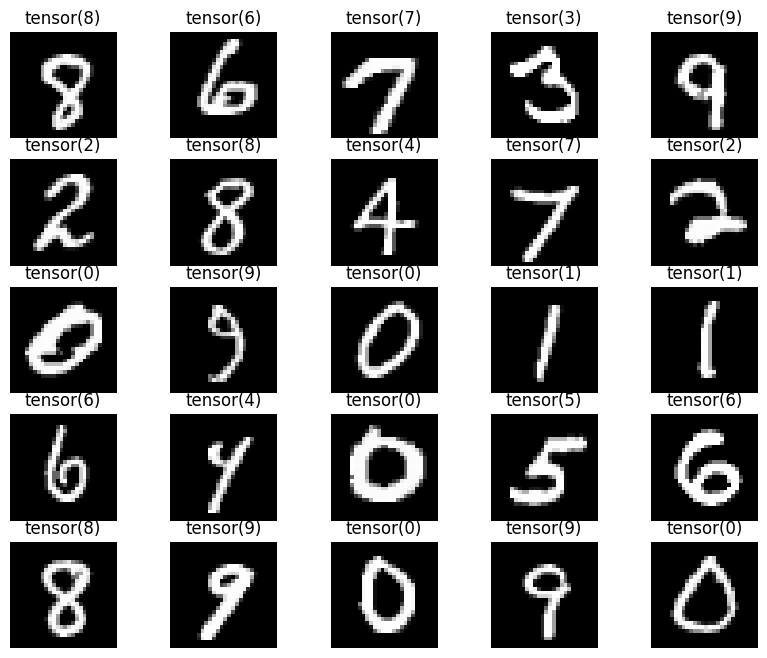

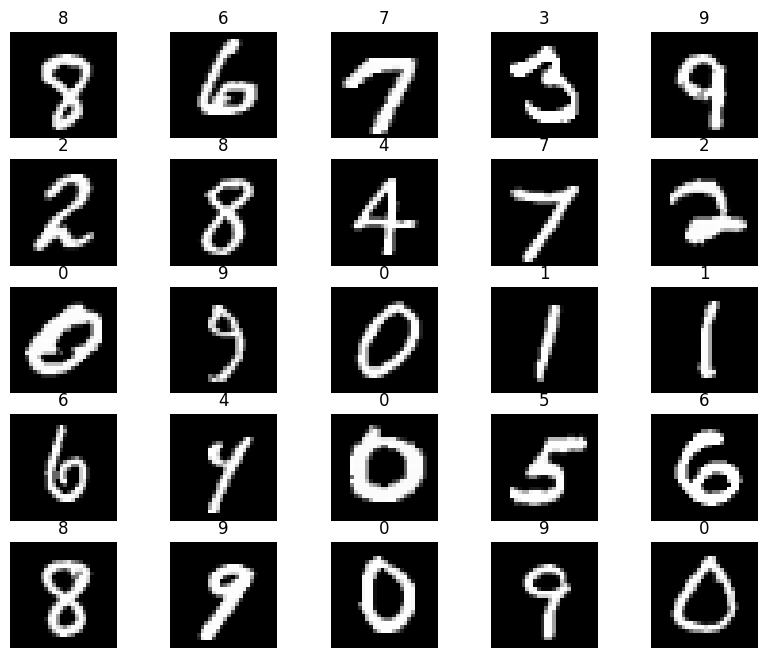

P: 8 A: 8 T: True
P: 6 A: 6 T: True
P: 7 A: 7 T: True
P: 3 A: 3 T: True
P: 9 A: 9 T: True
Nine True
P: 2 A: 2 T: True
P: 8 A: 8 T: True
P: 4 A: 4 T: True
P: 7 A: 7 T: True
P: 2 A: 2 T: True
P: 0 A: 0 T: True
Zero True
P: 9 A: 9 T: True
Nine True
P: 0 A: 0 T: True
Zero True
P: 1 A: 1 T: True
P: 1 A: 1 T: True
P: 6 A: 6 T: True
P: 4 A: 4 T: True
P: 0 A: 0 T: True
Zero True
P: 5 A: 5 T: True
P: 6 A: 6 T: True
P: 8 A: 8 T: True
P: 9 A: 9 T: True
Nine True
P: 0 A: 0 T: True
Zero True
P: 9 A: 9 T: True
Nine True
P: 0 A: 0 T: True
Zero True
Class nine detected


In [ ]:
test_and_show(sscnn_0to8_ft, loaders, text=True, graph_mode=2, rotate=False)

In [ ]:
for named_param in sscnn_0to8.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)

    # else:
      # print("\nSSCNN Others: ", named_param[0], named_param[1], named_param[1].requires_grad)

for named_param in sscnn_0to8_ft.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN ft: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight':
      print("\nSSCNN ft: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN ft: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNN ft Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

      # else:
      # print("\nSSCNNpA Others: ", named_param[0], named_param[1], named_param[1].requires_grad)


SSCNN:  conv1.weight tensor([[ 1.4629,  1.5484,  0.5125,  0.5943,  2.4912],
        [-0.0214,  1.3613,  1.1784,  1.8034,  1.4836],
        [-2.1880,  0.7160,  0.8190,  0.1612, -1.9535],
        [-3.6087, -1.7105, -2.0613, -2.8509, -2.8609],
        [-1.6882, -2.1607, -2.7544, -0.7828,  0.7039]],
       grad_fn=<SelectBackward0>) True

SSCNN:  conv1sa.weight tensor([[[ 0.3356]],

        [[ 0.3289]],

        [[-0.2564]]], grad_fn=<SelectBackward0>) True

SSCNN:  conv1pa.weight Parameter containing:
tensor([[[[-0.4525]]],


        [[[ 0.9910]]],


        [[[-0.4063]]]], requires_grad=True) True

SSCNN Others:  fc.weight tensor(0.0076, grad_fn=<SelectBackward0>) True

SSCNN Others:  out.weight tensor(-0.9598, grad_fn=<SelectBackward0>) True

SSCNN ft:  conv1.weight tensor([[ 0.1267, -0.1266, -1.2208, -1.7774, -0.7151],
        [-1.4307, -1.1892,  0.0475,  0.5886, -0.1246],
        [-1.5620, -0.3172,  2.6985,  2.5965,  0.8179],
        [-0.2329,  1.1855,  2.6382,  2.9880,  2.4498],
   